In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

from torchvision import datasets
from torchvision import transforms

torch.manual_seed(123)

In [2]:
data_path = "../data-unversioned/p1ch7/"

cifar10 = datasets.CIFAR10(data_path, train=True, download=True) # <1>
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True) # <2>

Files already downloaded and verified
Files already downloaded and verified


# 1

In [3]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.RandomCrop(32))

Files already downloaded and verified


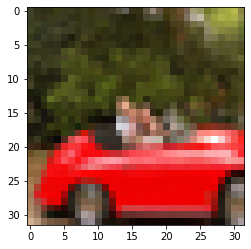

In [4]:
img_t, _ = transformed_cifar10[99]

plt.imshow(img_t)
plt.show()

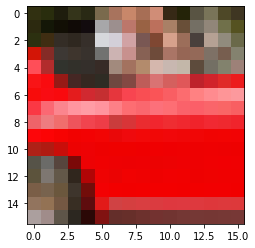

In [5]:
random_crop = transforms.RandomCrop(16)
img_t = random_crop(img_t)
plt.imshow(img_t)
plt.show()

In [19]:
crop_size = 32

transform_crop = transforms.Compose([
    transforms.RandomCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468),
                        (0.2470, 0.2435, 0.2616))
])

transform_no_crop = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468),
                        (0.2470, 0.2435, 0.2616))
])

cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transform_no_crop)

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transform_no_crop)

In [20]:
label_map = {0:0, 2:1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [21]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

In [23]:
import torch.nn as nn
import torch.optim as optim

input_size = crop_size * crop_size *3

model = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-3

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch:{epoch}, Loss:{float(loss)}')

Epoch:0, Loss:0.5466360449790955
Epoch:1, Loss:0.5225091576576233
Epoch:2, Loss:0.47977352142333984
Epoch:3, Loss:0.6509043574333191
Epoch:4, Loss:0.45363086462020874
Epoch:5, Loss:0.40073996782302856
Epoch:6, Loss:0.37475883960723877
Epoch:7, Loss:0.359598845243454
Epoch:8, Loss:0.3820255398750305
Epoch:9, Loss:0.2791224718093872
Epoch:10, Loss:0.43799087405204773
Epoch:11, Loss:0.5997544527053833
Epoch:12, Loss:0.27878567576408386
Epoch:13, Loss:0.5125641226768494
Epoch:14, Loss:0.3681667745113373
Epoch:15, Loss:0.5852469205856323
Epoch:16, Loss:0.5106897950172424
Epoch:17, Loss:0.29735809564590454
Epoch:18, Loss:0.43464574217796326
Epoch:19, Loss:0.565280020236969
Epoch:20, Loss:0.7232206463813782
Epoch:21, Loss:0.7109858393669128
Epoch:22, Loss:0.39549604058265686
Epoch:23, Loss:0.5280941128730774
Epoch:24, Loss:0.33712053298950195
Epoch:25, Loss:0.5083262920379639
Epoch:26, Loss:0.22186098992824554
Epoch:27, Loss:0.40120163559913635
Epoch:28, Loss:0.39216941595077515
Epoch:29, Los

In [25]:
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        batch_size = labels.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += batch_size
        correct += (predicted == labels).sum()

print(f'Accuracy:{correct / total}')

Accuracy:0.8550999760627747


In [26]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = labels.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += batch_size
        correct += (predicted == labels).sum()

print(f'Accuracy:{correct / total}')

Accuracy:0.8174999952316284


# 2.訓練関数の入れ替え(MSE)

確率ではなく、ラベルを数値に見立て回帰問題として学習する

In [27]:
import torch.nn as nn
import torch.optim as optim

input_size = crop_size * crop_size *3

model = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 1),)

learning_rate = 1e-3

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.MSELoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels.float())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch:{epoch}, Loss:{float(loss)}')

/home/takakiyuto/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/takakiyuto/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:0, Loss:0.2929607927799225
Epoch:1, Loss:0.27516230940818787
Epoch:2, Loss:0.26277509331703186
Epoch:3, Loss:0.2730470299720764
Epoch:4, Loss:0.25786709785461426
Epoch:5, Loss:0.2623669505119324
Epoch:6, Loss:0.26066920161247253
Epoch:7, Loss:0.2504061460494995
Epoch:8, Loss:0.24664434790611267
Epoch:9, Loss:0.2506788372993469
Epoch:10, Loss:0.25169312953948975
Epoch:11, Loss:0.25283095240592957
Epoch:12, Loss:0.2545141577720642
Epoch:13, Loss:0.2515367865562439
Epoch:14, Loss:0.25300365686416626
Epoch:15, Loss:0.25089752674102783
Epoch:16, Loss:0.2495119571685791
Epoch:17, Loss:0.25070565938949585
Epoch:18, Loss:0.24863584339618683
Epoch:19, Loss:0.248887836933136
Epoch:20, Loss:0.25135987997055054
Epoch:21, Loss:0.2517026364803314
Epoch:22, Loss:0.2500300705432892
Epoch:23, Loss:0.25164756178855896
Epoch:24, Loss:0.2508368492126465
Epoch:25, Loss:0.25010737776756287
Epoch:26, Loss:0.25156697630882263
Epoch:27, Loss:0.2509791851043701
Epoch:28, Loss:0.24935050308704376
Epoch:29,

In [32]:
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        batch_size = labels.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        outputs[outputs >= 0.5] = int(1)
        outputs[outputs <= 0.5] = int(0)
        outputs = outputs.squeeze()
        total += batch_size
        correct += (outputs == labels).sum()
        
print(f'Accuracy:{correct / total}')

Accuracy:0.520799994468689


# 3
ネットワークの容量を減らすことで、過学習を停止する

In [35]:

model = nn.Sequential(
            nn.Linear(input_size, 256),            
            nn.Tanh(),
            nn.Linear(256, 64),
            nn.Tanh(),
            nn.Linear(64, 2))

learning_rate = 1e-3

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 150


for epoch in range(n_epochs):
    train_loss = 0
    val_loss = 0
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)
    
    with torch.no_grad():
        for imgs, labels in val_loader:
            batch_size = labels.shape[0]
            outputs = model(imgs.view(batch_size, -1))
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
    
    if epoch % 10 == 0:
        print(f'Epoch:{epoch}, train_loss:{float(avg_train_loss)}, val_loss:{float(avg_val_loss)}')

Epoch:0, train_loss:0.5923285645664118, val_loss:0.541011325083673
Epoch:10, train_loss:0.47716009199239645, val_loss:0.4690235583111644
Epoch:20, train_loss:0.4549754582772589, val_loss:0.4551337594166398
Epoch:30, train_loss:0.43942800107275604, val_loss:0.44230358581990004
Epoch:40, train_loss:0.42716842472173605, val_loss:0.4354666816070676
Epoch:50, train_loss:0.41461211917506663, val_loss:0.43067983724176884
Epoch:60, train_loss:0.40294860996258486, val_loss:0.42420241329818964
Epoch:70, train_loss:0.3894062893595665, val_loss:0.4229659428820014
Epoch:80, train_loss:0.3758756472806262, val_loss:0.41838122718036175
Epoch:90, train_loss:0.36433552366912747, val_loss:0.415889086201787
Epoch:100, train_loss:0.3479366431570357, val_loss:0.4167009489610791
Epoch:110, train_loss:0.3323660311615391, val_loss:0.4123869384638965
Epoch:120, train_loss:0.31696975022364576, val_loss:0.41095075057819486
Epoch:130, train_loss:0.2997040340475216, val_loss:0.41050759609788656
Epoch:140, train_los

In [36]:
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        batch_size = labels.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += batch_size
        correct += (predicted == labels).sum()

print(f'Accuracy:{correct / total}')

Accuracy:0.902999997138977


In [37]:

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = labels.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += batch_size
        correct += (predicted == labels).sum()

print(f'Accuracy:{correct / total}')

Accuracy:0.8205000162124634
